# Space X First Stage Landing Prediction


## 1. Introduction

This project analyzes SpaceX Falcon 9 launch data to identify the factors that influence
the success of first-stage landings.

SpaceX has reduced launch costs by reusing the first stage (the bottom part of the rocket that helps it take off). Predicting whether it will return safely is essential for estimating mission costs, evaluating operational risks and understanding the factors that influence launch success.

In this project, I developed an end-to-end Machine Learning pipeline using historical SpaceX launch data with the following goals:

- Build a predictive model to classify whether the Falcon 9 first stage will land successfully  
- Explore and understand the features that influence landing outcomes  
- Compare multiple machine learning algorithms (Logistic Regression, SVM, Decision Tree)  
- Optimize hyperparameters using GridSearchCV  
- Identify the best-performing model based on evaluation metrics  

This notebook follows a clear workflow, combining:

* Data Collection (API + Web Scraping)
* Exploratory Data Analysis (EDA)
* Geospatial visualization with Folium
* Feature Engineering
* Machine Learning Modeling
* Interpretation of Results


## 2. Import Libraries

In [56]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_style("whitegrid")

## 3. Data Collection and Loading
In this section, we explain where the raw data for this project comes from and how it was transformed into the datasets used in this notebook.
The goal is to demonstrate data collection skills (API requests and web scraping) while keeping the focus on analysis and modeling.

The final, cleaned datasets are then loaded, converted into DataFrames, and briefly overviewed.

---

### 3.1. API Request (SpaceX REST API)

The main dataset was built by requesting data from the SpaceX REST API.
Multiple endpoints were queried and later combined to create a comprehensive view of Falcon 9 missions.

**API endpoints used:**

- Rockets: [https://api.spacexdata.com/v4/rockets/](https://api.spacexdata.com/v4/rockets/)
- Launchpads: [https://api.spacexdata.com/v4/launchpads/](https://api.spacexdata.com/v4/launchpads/)
- Payloads: [https://api.spacexdata.com/v4/payloads/](https://api.spacexdata.com/v4/payloads/)

Below is a minimal example illustrating how the data was retrieved using an API request:


In [57]:
# Minimal API request example
url = "https://api.spacexdata.com/v4/rockets/"
response = requests.get(url)
rockets_data = response.json()
df_rockets = pd.json_normalize(rockets_data)
df_rockets.head()

,payload_weights,flickr_images,name,type,active,stages,boosters,cost_per_launch,success_rate_pct,first_flight,...,engines.number,engines.type,engines.version,engines.layout,engines.engine_loss_max,engines.propellant_1,engines.propellant_2,engines.thrust_to_weight,landing_legs.number,landing_legs.material
0,"[{'id': 'leo', 'name': 'Low Earth Orbit', 'kg'...","[https://imgur.com/DaCfMsj.jpg, https://imgur....",Falcon 1,rocket,False,2,0,6700000,40,2006-03-24,...,1,merlin,1C,single,0.0,liquid oxygen,RP-1 kerosene,96.0,0,None
1,"[{'id': 'leo', 'name': 'Low Earth Orbit', 'kg'...",[https://farm1.staticflickr.com/929/2878733830...,Falcon 9,rocket,True,2,0,50000000,98,2010-06-04,...,9,merlin,1D+,octaweb,2.0,liquid oxygen,RP-1 kerosene,180.1,4,carbon fiber
2,"[{'id': 'leo', 'name': 'Low Earth Orbit', 'kg'...",[https://farm5.staticflickr.com/4599/385838292...,Falcon Heavy,rocket,True,2,2,90000000,100,2018-02-06,...,27,merlin,1D+,octaweb,6.0,liquid oxygen,RP-1 kerosene,180.1,12,carbon fiber
3,"[{'id': 'leo', 'name': 'Low Earth Orbit', 'kg'...",[https://live.staticflickr.com/65535/489541389...,Starship,rocket,False,2,0,7000000,0,2021-12-01,...,37,raptor,,None,NaN,liquid oxygen,liquid methane,107.0,6,stainless steel


> Only a minimal snippet is shown here.
The full dataset used in this project was **cleaned, merged, filtered, and engineered** from multiple API responses before being saved as CSV files.

### 3.2. Web Scraping (Wikipedia)

In addition to the API data, web scraping was used to collect historical launch information from Wikipedia, illustrating an alternative data collection method.

**Source:**

Wikipedia page: https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

The data was extracted using *BeautifulSoup*, parsed from HTML tables, and transformed into structured tabular format.

For this project:

- Web scraping is presented to demonstrate data acquisition skills
- The final analysis uses processed CSV files derived from these steps, rather than the raw scraped tables
- Full scraping code is omitted for simplicity and clarity

### 3.3 Load Datasets

The datasets resulting from the steps above have been **cleaned, filtered, and preprocessed** before being saved as CSV files.
At this stage, they are loaded for analysis and machine learning.

These datasets consolidate information collected via **API requests and web scraping**.

In [58]:
# Load dataset Part 1: Launch records
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [59]:
# Load dataset Part 2: Feature matrix for ML
URL2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
X = pd.read_csv(URL2)
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


We will work with two datasets:

1. **Launch Records (data)**:
Contains cleaned historical Falcon 9 launch data, used for exploratory data analysis and visualization.

2. **Feature Matrix (X)**:
Contains preprocessed and encoded features ready for training machine learning models to predict landing success.

### 3.4 Dataset Description

From the loaded datasets, we will use the following features for analysis and modeling:

* Launch site
* Booster version
* Payload mass
* Orbit type
* Flight number
* Landing outcome **(target variable)**

## 4. Exploratory Data Analysis (EDA)

The objective of this Exploratory Data Analysis (EDA) is to understand the structure of the dataset, identify patterns related to landing success, and extract insights that support feature selection for the machine learning stage.

### 4.1 Basic Statistics

We start by examining the dataset structure, data types, and basic statistics to helps verify data quality and ensures the data is ready for machine learning.



In [60]:
print("Launch Records dataset shape:", data.shape)
print("Feature Matrix dataset shape:", X.shape)
print("")
data.info()
data.describe()


Launch Records dataset shape: (90, 18)
Feature Matrix dataset shape: (90, 83)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Lat

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,-86.366477,29.449963,0.666667
std,26.124701,4694.671720,1.213172,1.595288,1.710254,14.149518,2.141306,0.474045
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857,0.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,-80.577366,28.608058,1.000000
max,90.000000,15600.000000,6.000000,5.000000,5.000000,-80.577366,34.632093,1.000000


**Observations**:

- The dataset contains historical records of Falcon 9 launches with numerical and categorical features such as `PayloadMass`, `LaunchSite` and `FlightNumber`.
- The target variable `Class` indicates whether the first stage landing was successful (`1`) or not (`0`).
- The data types are consistent and no critical missing values are observed, confirming that the dataset is suitable for supervised learning.

### 4.2 Visual Exploratory Analysis

We now explore relationships between mission characteristics and landing outcomes using visualizations.
These plots help identify trends and patterns that may influence model performance.

#### Payload Mass Distribution

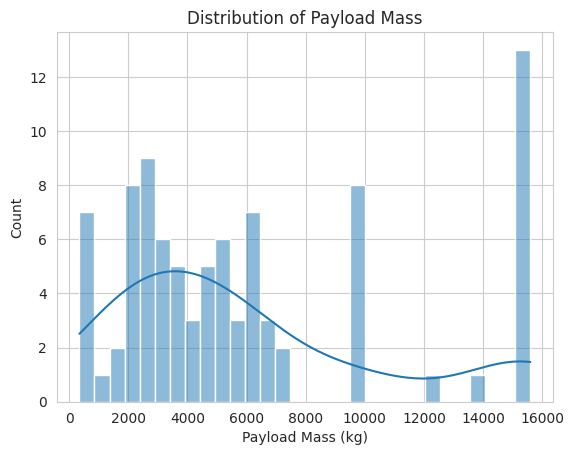

In [61]:
# Histogram of PayLload Mass
sns.histplot(data['PayloadMass'], bins=30, kde=True)
plt.title('Distribution of Payload Mass')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Count')
plt.show()

The payload mass shows a wide distribution, indicating that missions vary significantly in complexity.
This suggests that payload mass may influence landing success and should be considered during feature selection.


#### Payload Mass by Launch Site

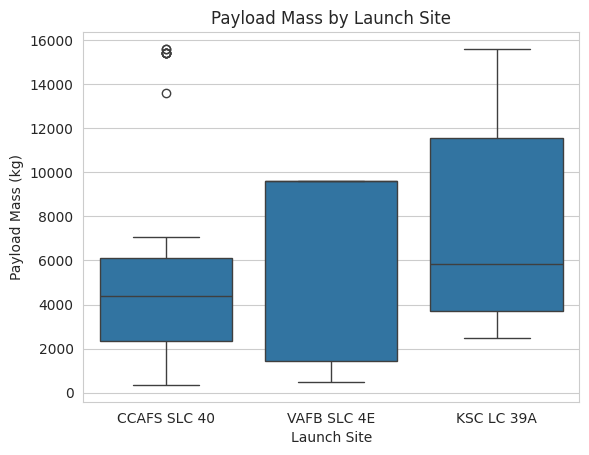

In [62]:
# Boxplot of Payload Mass by Launch Site
sns.boxplot(x='LaunchSite', y='PayloadMass', data=data)
plt.title('Payload Mass by Launch Site')
plt.xlabel('Launch Site')
plt.ylabel('Payload Mass (kg)')
plt.show()

Different launch sites operate with different payload profiles.
This indicates that launch site is an important categorical feature for predicting landing success.


#### Flight Number vs Landing Outcome

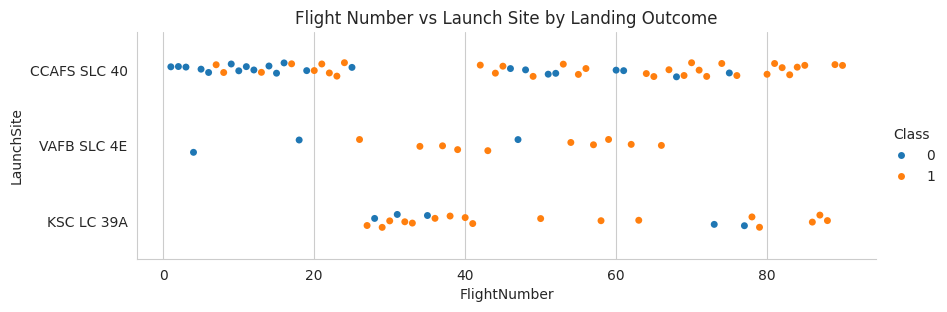

In [63]:
# Scatter plot of Flight Number vs Launch Site
sns.catplot(x="FlightNumber", y="LaunchSite", hue="Class", data=data, aspect=3, height=3, kind="strip")
plt.title("Flight Number vs Launch Site by Landing Outcome")
plt.show()

Later flight numbers are associated with higher landing success rates.
This reflects SpaceX's learning curve over time and suggests that flight number captures operational maturity.


### 4.3 Geographic Visualization (Folium Map)


To complement the statistical analysis, we visualize the geographic locations of launch sites using an interactive map.
This helps contextualize launch operations spatially.


In [64]:
# Launch sites coordinates
launch_coords = {'CCAFS SLC-40': [28.563197, -80.576820],
    'KSC LC-39A': [28.573255, -80.646895],'VAFB SLC-4E': [34.632834, -120.610745]}

# Folium map
site_map = folium.Map(location=[30, -95], zoom_start=4)

for site, coords in launch_coords.items():
    folium.Marker(
        location=coords,
        popup=site,
        icon=folium.Icon(color='blue', icon='rocket')
    ).add_to(site_map)
site_map

The map shows that SpaceX operates from both the East and West coasts of the United States.
Geographic location may influence mission profiles, orbits, and operational constraints, reinforcing the relevance of launch site as a model feature.

### 4.4 Summary of EDA Findings

The exploratory analysis highlights that:
- Landing success increases with flight number, reflecting operational experience.
- Payload mass and launch site vary significantly across missions.
- Geographic and operational factors are relevant for modeling landing outcomes.

These insights guide feature selection and justify the use of supervised machine learning to predict first stage landing success.

## 5. Machine Learning Preparation

Before training the machine learning models, we prepare the data by defining the target variable, scaling the feature set, and splitting the data into training and testing subsets.


### 5.1 Target Variable Definition

The target variable represents whether the Falcon 9 first-stage booster landed successfully.

- **Class = 1** - Successful landing

- **Class = 0** - Failed landing

We extract this column from the launch records dataset and convert it into a NumPy array for modeling.

In [65]:
# Define target variable
Y = data['Class'].to_numpy()
# Preview target values
Y[:5]

array([0, 0, 0, 0, 0])

### 5.2 Feature Matrix Preparation and Scaling

The feature matrix X contains the numerical and encoded categorical features used by the machine learning models.

Since many algorithms (such as Logistic Regression, SVM, and KNN) are sensitive to feature scale, we standardize the features using StandardScaler.
This transformation ensures that all features have comparable ranges and prevents features with large magnitudes from dominating the learning process.



In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reassign scaled features
X = X_scaled

### 5.3 Train–Test Split

To evaluate model performance on unseen data, we split the dataset into training and testing subsets.

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2)
# Check test set size
Y_test.shape

(18,)

> The test set contains 18 samples, which reflects the relatively small size of the dataset.


#### **Section Summary**

- The target variable is clearly defined  
- Features are standardized for fair model comparison  
- Data is split into training and test sets for evaluation  

## 6. Machine Learning Models

In this section, we train and evaluate different supervised learning models to predict whether the Falcon 9 first stage will land successfully.

Due to the relatively small dataset size, model performance is evaluated using both cross-validation accuracy and test set accuracy. In addition to accuracy, we analyze error patterns to better understand model behavior.


### 6.1 Logistic Regression

Logistic Regression is used as a **baseline model** due to its simplicity and interpretability  for binary classification problems.

We tune the regularization strength `C` using cross-validation.

In [68]:
parameters = {'C': [0.01, 0.1, 1],
              'penalty': ['l2'],'solver': ['lbfgs']}

lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

print("Best parameters:", logreg_cv.best_params_)
print("Cross-validation accuracy:", round(logreg_cv.best_score_, 4))

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation accuracy: 0.8464


#### Test Performance

In [69]:
yhat_lr = logreg_cv.predict(X_test)
print("Test accuracy:", round(accuracy_score(Y_test, yhat_lr),4))


Test accuracy: 0.8333


#### Confusion Matrix

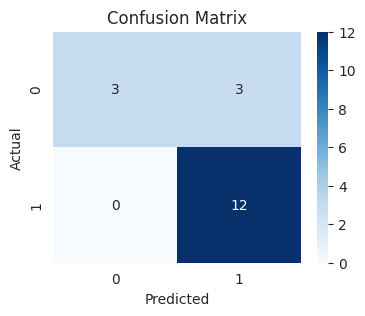

In [70]:
cm = confusion_matrix(Y_test, yhat_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Observations**

Logistic Regression achieves solid performance and serves as a strong baseline. Most errors are **false positives**, meaning the model sometimes predicts a successful landing when the booster actually fails. This suggests the model is slightly optimistic when predicting success.

### 6.2 Support Vector Machine (SVM)

Support Vector Machines are effective at modeling **non-linear decision boundaries**, which can be useful for complex relationships between features.

In [71]:
parameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-3, 3, 5), 'gamma': np.logspace(-3, 3, 5)}

svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

print("Best parameters:", svm_cv.best_params_)
print("Cross-validation accuracy:", round(svm_cv.best_score_, 4))

Best parameters: {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
Cross-validation accuracy: 0.8482


#### Test Performance

In [72]:
yhat_svm = svm_cv.predict(X_test)
print("Test accuracy:", round(accuracy_score(Y_test, yhat_svm),4))

Test accuracy: 0.8333


**Observations**

The SVM model performs competitively and captures non-linear patterns in the data. However, its test performance is similar to Logistic Regression, indicating that the added complexity does not significantly improve generalization for this dataset.

### 6.3 Decision Tree Classifier

Decision Trees are intuitive and easy to interpret, and they naturally model non-linear relationships without requiring feature scaling.

In [73]:
parameters = {'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8],'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

print("Best parameters:", tree_cv.best_params_)
print("Cross-validation accuracy:", round(tree_cv.best_score_,4))


Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 10}
Cross-validation accuracy: 0.8179


#### Test Performance

In [74]:
yhat_tree = tree_cv.predict(X_test)
print("Test accuracy:", round(accuracy_score(Y_test, yhat_tree),4))

Test accuracy: 0.8333


**Observations**

The Decision Tree achieves similar test performance but shows signs of **overfitting**, which is common with tree-based models on small datasets. The shallow optimal depth suggests that simpler trees generalize better in this case.

### 6.4 K-Nearest Neighbors (KNN)

KNN classifies samples based on similarity to nearby data points and can be sensitive to dataset size and feature scaling.

In [75]:
parameters = {'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2]}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

print("Best parameters:", knn_cv.best_params_)
print("Cross-validation accuracy:", round(knn_cv.best_score_,4))

Best parameters: {'n_neighbors': 7, 'p': 1}
Cross-validation accuracy: 0.8464


#### Test Performance

In [76]:
yhat_knn = knn_cv.predict(X_test)
print("Test accuracy:", round(accuracy_score(Y_test, yhat_knn),4))

Test accuracy: 0.8333


**Observations**

KNN performs similarly to the other models but is more sensitive to the small dataset size. Its performance is stable but does not offer advantages over simpler or more interpretable models.


## 6.5 Model Comparison and Selection

All evaluated models achieved the same test accuracy (83%), which is expected given:

- The small size of the test set (18 samples)
- Similar information captured by the feature set
- Limited data variability


In [77]:
models = {
    "Logistic Regression": round(accuracy_score(Y_test, yhat_lr),4),
    "SVM": round(accuracy_score(Y_test, yhat_svm),4),
    "Decision Tree": round(accuracy_score(Y_test, yhat_tree),4),
    "KNN": round(accuracy_score(Y_test, yhat_knn),4)}

models

{'Logistic Regression': 0.8333,
 'SVM': 0.8333,
 'Decision Tree': 0.8333,
 'KNN': 0.8333}

**Model Selection**

Although all models show identical test accuracy, **Logistic Regressio**n stands out as the preferred model due to:

- Strong baseline performance
- Better interpretability
- Lower risk of overfitting
- Simpler deployment and explanation


## 7. Conclusion

In this project, we built a complete machine learning workflow to predict whether a Falcon 9 first-stage booster lands successfully.

The project covered all main steps of a data science pipeline, including:

- Data collection from the SpaceX API
- Data cleaning and feature preparation
- Exploratory data analysis (EDA)
- Training and evaluation of multiple classification models

Several models were tested, such as Logistic Regression, SVM, Decision Tree, and KNN. Due to the small dataset and limited test samples, all models achieved very similar performance on the test set.

Logistic Regression stood out as a strong baseline model, offering good performance while remaining easy to interpret. More complex models did not show clear improvements under the current data conditions.

Overall, this notebook demonstrates the ability to:

- Structure an end-to-end ML project
- Apply proper preprocessing and model evaluation techniques
- Analyze results critically rather than relying only on metrics
- Communicate findings in a clear and organized way

## 8. Future Improvements

There are several ways this project could be extended or improved in the future:

- **More data**: Including additional launches would improve model stability and generalization.
- **Feature engineering**: Adding information such as weather conditions, launch timing, or booster reuse could enhance predictive power.
- **Additional metrics**: Using precision, recall, or F1-score would provide a more detailed evaluation than accuracy alone.
- **More advanced models**: Ensemble methods like Random Forests or Gradient Boosting could capture more complex patterns.

These improvements would help build a more robust and realistic predictive model.